In [1]:
!pip install -q kaggle
%load_ext tensorboard
import datetime
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import *
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

from google.colab import drive

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#from google.colab import files
#files.upload()

#!mkdir -p ~/.kaggle
#!mv kaggle.json ~/.kaggle/
#!kaggle competitions download -c facial-keypoints-detection

#!unzip training.zip
#!unzip test.zip

In [3]:
TRAIN_DIR = "/content/drive/My Drive/Facial_keypoint/training.csv"
TEST_DIR = "/content/drive/My Drive/Facial_keypoint/test.csv"

In [4]:
train_df = pd.read_csv(TRAIN_DIR)
train_df.columns

Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y', 'Image'],
      dtype='object')

In [5]:
train_df.isnull().any().value_counts()

True     28
False     3
dtype: int64

In [6]:
train_df.fillna(method = 'ffill',inplace = True)

In [7]:
img = train_df['Image']
print(img.shape)
print(type(img[0]))

keypoints = train_df.loc[:,'left_eye_center_x' : 'mouth_center_bottom_lip_y'].to_numpy()
print(type(keypoints))
print(keypoints.shape)

n_keypoints = keypoints.shape[1]
print(n_keypoints)

(7049,)
<class 'str'>
<class 'numpy.ndarray'>
(7049, 30)
30


In [8]:
train_images = []
for i in range(img.shape[0]):
  im = img[i].split(' ')
  if all(im) == False:
    im = ['0' if x == '' else x for x in im]
  train_images.append(im)

In [9]:
train_images = np.array(train_images, dtype='float')
print(train_images.shape)

(7049, 9216)


In [10]:
train_images = train_images.reshape(-1, 96, 96, 1)

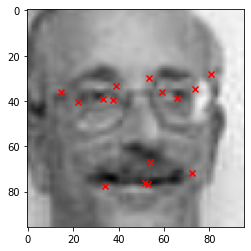

In [11]:
idx = np.random.randint(0, 7049)
plt.imshow(train_images[idx].reshape(96, 96), cmap='gray')

px = 0
while px < n_keypoints:
  x = keypoints[idx][px]
  y = keypoints[idx][px + 1]

  plt.scatter([[x]], [[y]],c = 'r', marker='x')
  px += 2


In [20]:
model = tf.keras.Sequential()
model.add(Conv2D(64, (5, 5), strides = (2,2), activation='relu', input_shape = (96, 96, 1)))
model.add(Conv2D(64, (5, 5),strides = (2,2), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(96, (5, 5),strides = (2,2), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dense(n_keypoints, activation = 'linear'))

In [13]:
model = tf.keras.Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', input_shape = (96, 96, 1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(96, (3, 3), activation='relu'))
model.add(Conv2D(96, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dense(n_keypoints, activation = 'linear'))

In [21]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 46, 46, 64)        1664      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 21, 21, 64)        102464    
_________________________________________________________________
batch_normalization_4 (Batch (None, 21, 21, 64)        256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 3, 3, 96)          153696    
_________________________________________________________________
batch_normalization_5 (Batch (None, 3, 3, 96)          384       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 1, 1, 96)         

In [22]:
model.compile(optimizer='adam',
              loss = 'mse',
              metrics = ['mae'])

model.fit(train_images, keypoints, epochs= 50, batch_size= 32, validation_split= 0.1)

Epoch 1/50
199/199 [==============================] - 4s 20ms/step - loss: 379.8487 - mae: 12.5759 - val_loss: 86.9659 - val_mae: 7.2049
Epoch 2/50
199/199 [==============================] - 3s 17ms/step - loss: 65.2466 - mae: 6.0209 - val_loss: 101.7537 - val_mae: 7.7540
Epoch 3/50
199/199 [==============================] - 3s 17ms/step - loss: 54.5873 - mae: 5.4774 - val_loss: 159.6389 - val_mae: 11.0025
Epoch 4/50
199/199 [==============================] - 3s 17ms/step - loss: 47.4076 - mae: 5.1204 - val_loss: 18.9745 - val_mae: 3.1171
Epoch 5/50
199/199 [==============================] - 3s 17ms/step - loss: 42.8014 - mae: 4.8565 - val_loss: 49.9266 - val_mae: 6.0695
Epoch 6/50
199/199 [==============================] - 3s 17ms/step - loss: 37.8001 - mae: 4.5356 - val_loss: 13.7487 - val_mae: 2.6201
Epoch 7/50
199/199 [==============================] - 3s 17ms/step - loss: 34.7339 - mae: 4.3653 - val_loss: 12.2245 - val_mae: 2.5050
Epoch 8/50
199/199 [==============================

In [20]:
model.save('/content/drive/My Drive/Facial_keypoint/facial_keypoint200.h5')

In [38]:
test_model = tf.keras.models.load_model('/content/drive/My Drive/Facial_keypoint/facial_keypoint200.h5')

In [23]:
test_df = pd.read_csv(TEST_DIR)
print(test_df.columns)
test_df.head()

Index(['ImageId', 'Image'], dtype='object')


,ImageId,Image
0,1,182 183 182 182 180 180 176 169 156 137 124 10...
1,2,76 87 81 72 65 59 64 76 69 42 31 38 49 58 58 4...
2,3,177 176 174 170 169 169 168 166 166 166 161 14...
3,4,176 174 174 175 174 174 176 176 175 171 165 15...
4,5,50 47 44 101 144 149 120 58 48 42 35 35 37 39 ...


In [24]:
test_img = test_df['Image']
print(type(test_img[0]))
print(test_img.shape)

<class 'str'>
(1783,)


In [25]:
test_images = []
for i in range(test_img.shape[0]):
  im = test_img[i].split(' ')
  if all(im) == False:
    im = ['0' if x == '' else x for x in im]
  test_images.append(im)

In [29]:
test_images = np.array(test_images, dtype='float').reshape(-1, 96, 96, 1)

In [30]:
print(test_images.shape)
print(test_images[0].shape)

(1783, 96, 96, 1)
(96, 96, 1)


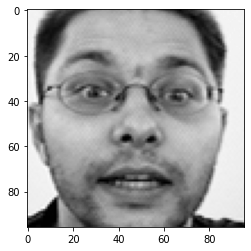

In [33]:
plt.imshow(test_images[0].reshape(96, 96), cmap='gray')

In [39]:
pred_keypoints = test_model.predict(test_images)

In [40]:
print(pred_keypoints.shape)

(1783, 30)


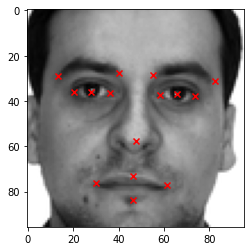

In [49]:
idx = np.random.randint(0, 1783)
plt.imshow(test_images[idx].reshape(96, 96), cmap='gray')

px = 0
while px < n_keypoints:
  x = pred_keypoints[idx][px]
  y = pred_keypoints[idx][px + 1]

  plt.scatter([[x]], [[y]],c = 'r', marker='x')
  px += 2

In [43]:
lookup_df = pd.read_csv('/content/drive/My Drive/Facial_keypoint/IdLookupTable.csv')
print(lookup_df.columns)
print(lookup_df.head())

Index(['RowId', 'ImageId', 'FeatureName', 'Location'], dtype='object')
   RowId  ImageId              FeatureName  Location
0      1        1        left_eye_center_x       NaN
1      2        1        left_eye_center_y       NaN
2      3        1       right_eye_center_x       NaN
3      4        1       right_eye_center_y       NaN
4      5        1  left_eye_inner_corner_x       NaN


In [50]:
lookup_id = list(lookup_df['FeatureName'])
imageID = list(lookup_df['ImageId']-1)
pred = list(pred_keypoints)

In [51]:
rowid = lookup_df['RowId']
rowid=list(rowid)

In [52]:
feature = []
for f in list(lookup_df['FeatureName']):
    feature.append(lookup_id.index(f))

In [54]:
preded = []
for x,y in zip(imageID,feature):
    preded.append(pred[x][y])

In [55]:
rowid = pd.Series(rowid,name = 'RowId')

In [56]:
loc = pd.Series(preded,name = 'Location')

In [57]:
submission = pd.concat([rowid,loc],axis = 1)

In [58]:
submission.to_csv('/content/drive/My Drive/Facial_keypoint/face_key_detection_submission.csv',index = False)